In [1]:
#notebooks/eda.ipynb

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Set style
sns.set(style = "whitegrid")

In [4]:
#Load cleaned and transformed dataset
df = pd.read_csv("../data/processed/clean_consumer_complaints.csv", low_memory = False)
print(df.shape)
df.head()

(66806, 11)


,product,sub_product,issue,company,state,timely_response,text_cleaned,consumer_disputed_binary,timely_response_binary,company_response_encoded,text_length
0,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,"Diversified Consultants, Inc.",NY,Yes,xxxx has claimed i owe them for xxxx years des...,0,1,1,52
1,Consumer Loan,Vehicle loan,Managing the loan or lease,M&T Bank Corporation,VA,Yes,due to inconsistencies in the amount owed that...,0,1,1,238
2,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",Wells Fargo & Company,CA,Yes,in xxxxxxxx my wages that i earned at my job d...,1,1,1,655
3,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",JPMorgan Chase & Co.,CA,Yes,i have an open and current mortgage with chase...,1,1,1,74
4,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,Rushmore Loan Management Services LLC,CA,Yes,xxxx was submitted xxxxxxxx at the time i subm...,1,1,1,259


#### Missing Values and Data quality

In [5]:
# Calculate missing percentages
missing_pct = df.isnull().mean().sort_values(ascending=False)
missing_pct

sub_product                 0.306185
product                     0.000000
issue                       0.000000
company                     0.000000
state                       0.000000
timely_response             0.000000
text_cleaned                0.000000
consumer_disputed_binary    0.000000
timely_response_binary      0.000000
company_response_encoded    0.000000
text_length                 0.000000
dtype: float64

#### Insights
* sub_product has ~30% missing values; other are complete.
* Text narrative is fully populated (cleaned text provided).
#### Strategy
* Impute sub_product missing values as 'Unknown' for modeling.
* No further dropping of comlumns necessary.

## Basic Feature Distributions

### Complaint Length

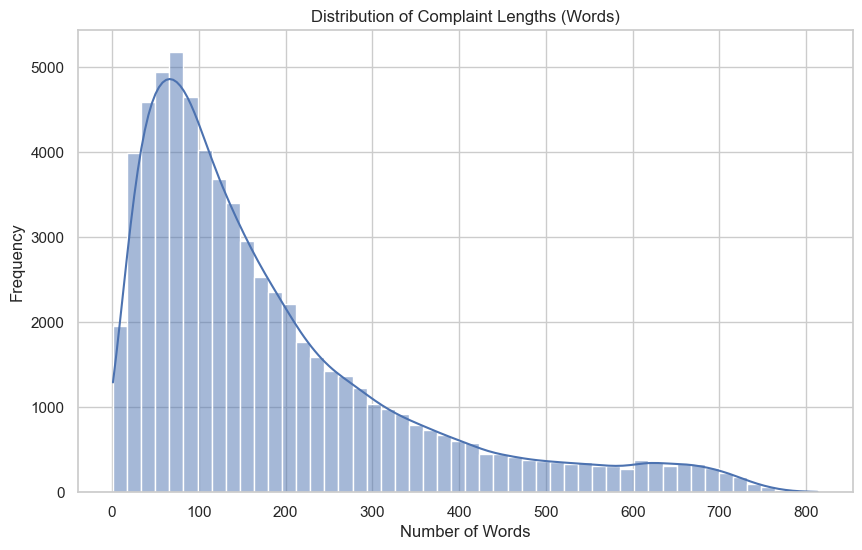

In [6]:
plt.figure(figsize = (10,6))
sns.histplot(df["text_length"], bins=50, kde = True)
plt.title("Distribution of Complaint Lengths (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

#### Insights
* Highly right-skewed distribution
* Longer complaints tend to be more emotionally driven -> potential sentiment signal
#### Strategy
* Cap length at 500 to reduce long-tail impact in modeling 
* Supports H2: Negative or detailed narrative correalte with disputes

### Dispute Distribution

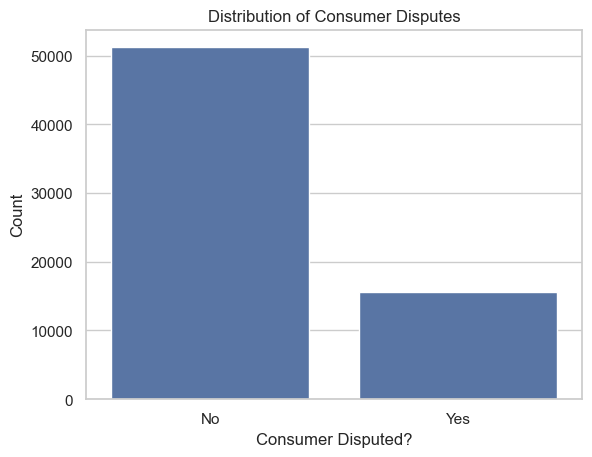

In [7]:
sns.countplot(data = df, x = "consumer_disputed_binary")
plt.title("Distribution of Consumer Disputes")
plt.xticks([0,1], ['No', 'Yes'])
plt.xlabel("Consumer Disputed?")
plt.ylabel("Count")
plt.show()

#### Insights:
* Dispute class is imbalanced(~80% non disputed vs 20% disputed)
#### Strategy
* Use SMOTE undersampling or class weights in model training.
* Ensure stratified splits to preserve class ratio

### Timely Response & Company Response Encoding

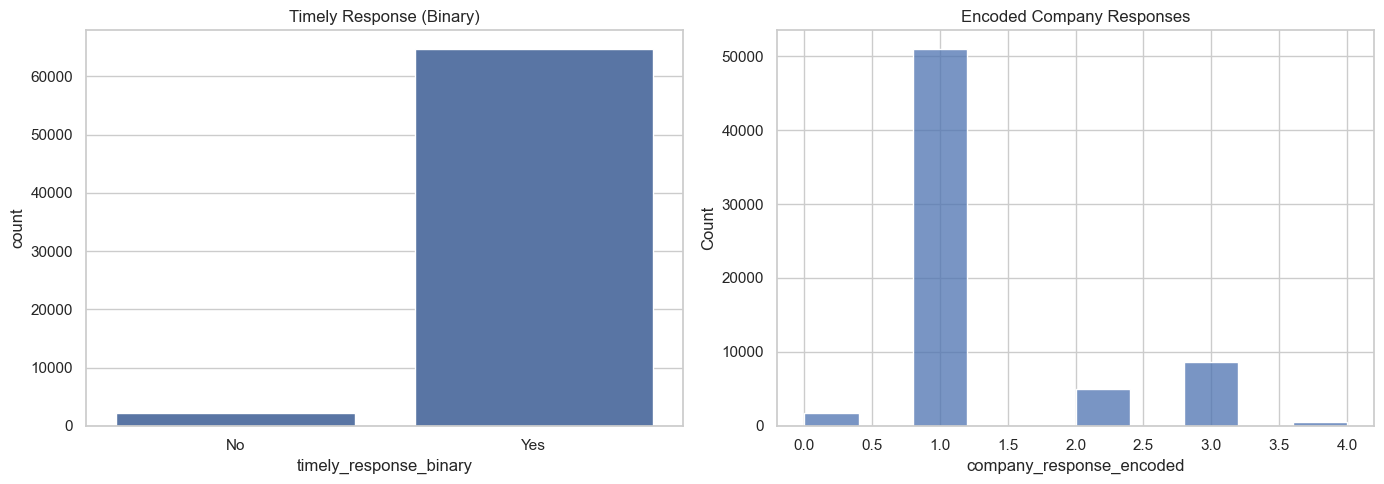

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.countplot(data=df, x="timely_response_binary", ax = ax[0])
sns.histplot(df["company_response_encoded"],bins=10, ax=ax[1], kde=False)

ax[0].set_title("Timely Response (Binary)")
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['No','Yes'])
ax[1].set_title("Encoded Company Responses")
plt.tight_layout()
plt.show()

### timely_response_binary
* Distribution
  * 96.75% timely(1)
  * 3.25% not timely(0)
* Impact on Disputes
  * 23.6% of timely responses were disputed
  * 15.4% of late responses were disputed
* Surprisingly, disputes are higher with timely responses
* Insights<br>
   * Contrary to expectation, timely response does not gurantee lower disputes<br>
   * Weak evidence for <b>H2</b>- suggests sentiment or resolution may matter more than timing

<br>
<br>

### company_response_encoded
* Distribution
  * Top response(code 1): ~76% of all responses
  * Only 5 unique reponse types used
* Insight
  * Response type is highly skewed
  * May need semantic grouping for better modeling
  * Categorical encoding for now

# Key Categorical Features Exploration 

### Most Common Issues and Product

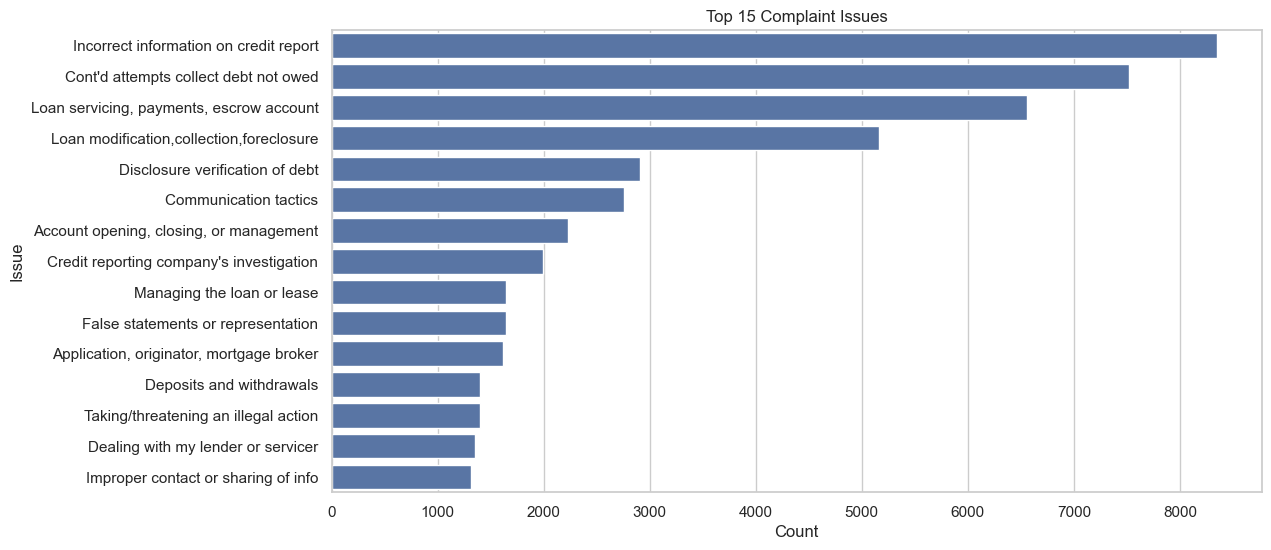

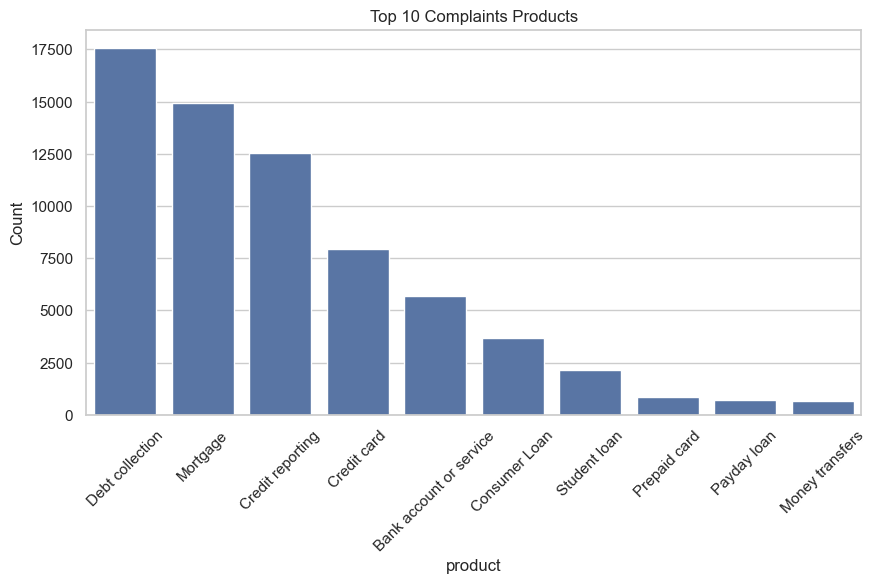

In [9]:
top_issues = df["issue"].value_counts().head(15)
top_products = df["product"].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(y = top_issues.index, x = top_issues.values)
plt.title("Top 15 Complaint Issues")
plt.xlabel("Count")
plt.ylabel("Issue")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title("Top 10 Complaints Products")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

### product(H1)
#### Insights
* Debt collection, Mortgage, Credit reporting dominate compliant volumes.
* Supports <br>H1</b> Certain products (like credit reporting) receive disproportionately high complaints
#### Strategy
* Encode top 5 products individually; group others as 'Other'
* Use product frequency for stratified sampling during model training.

### Product vs Dispute Rate

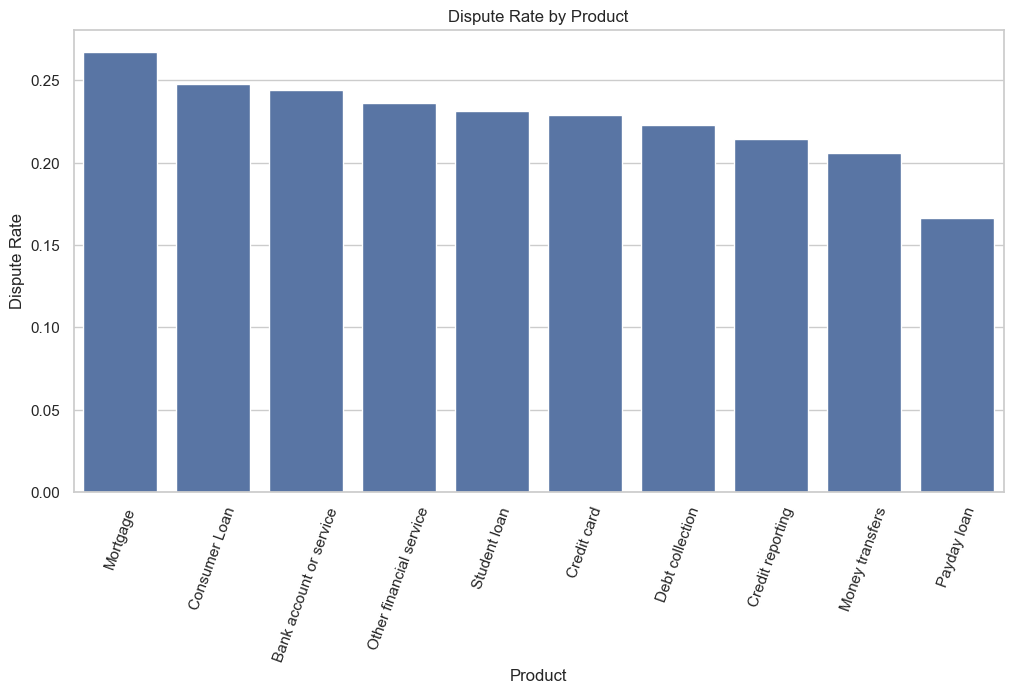

In [10]:
dispute_by_product = df.groupby("product")["consumer_disputed_binary"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=dispute_by_product.index, y=dispute_by_product.values)
plt.title("Dispute Rate by Product")
plt.ylabel("Dispute Rate")
plt.xlabel("Product")
plt.xticks(rotation=70)
plt.show()

### Dispute Rate By Product
* Highest in Mortgage(26.7%) and Consumer Loan(24.8%)

#### Insight
* Strong support for <b>H1: Certain products receive more complaints</b>
* Dispute rate varies significantly -> important modeling feature
#### Strategy
* Create new feature product_dispute _rate
* Consider weighting samples by dispute rate during model training.

### Geographic Distribution(State-Level)

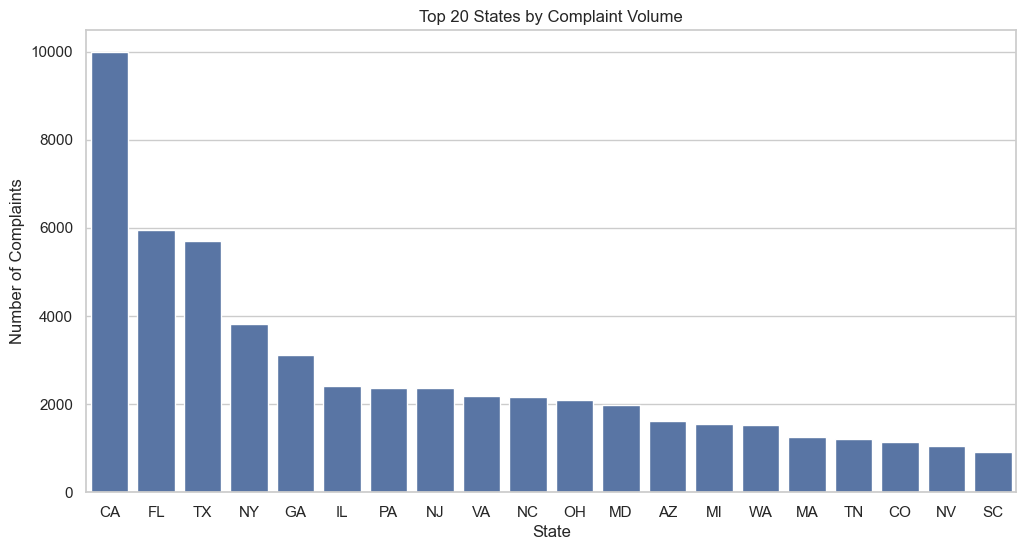

In [11]:
state_counts = df["state"].value_counts().head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=state_counts.index, y=state_counts.values)
plt.title("Top 20 States by Complaint Volume")
plt.ylabel("Number of Complaints")
plt.xlabel("State")
plt.show()

### Correlation Analysis(Numerical Fields)

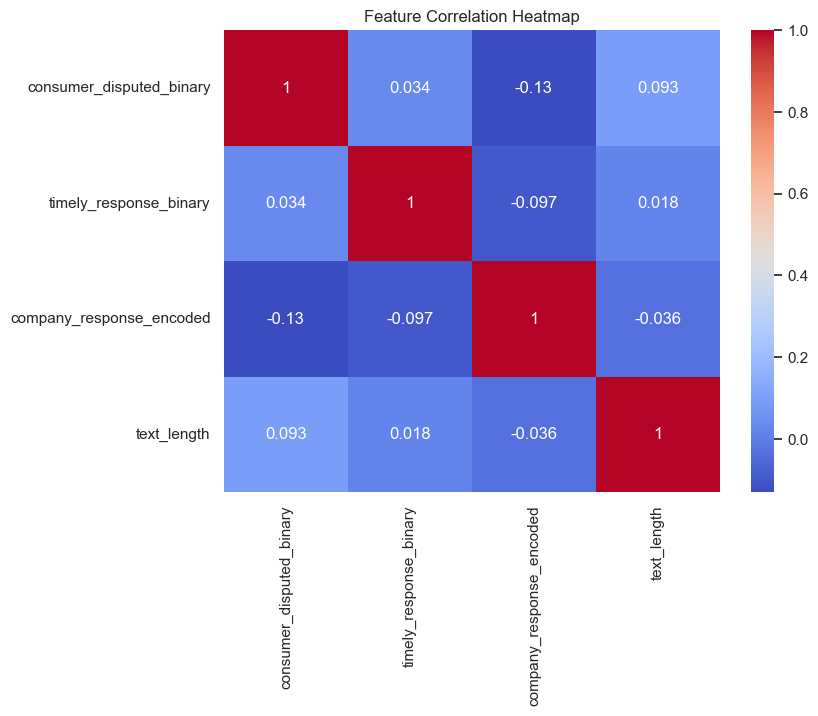

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["consumer_disputed_binary","timely_response_binary","company_response_encoded","text_length"]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

### Company Complaint Analysis (H3)


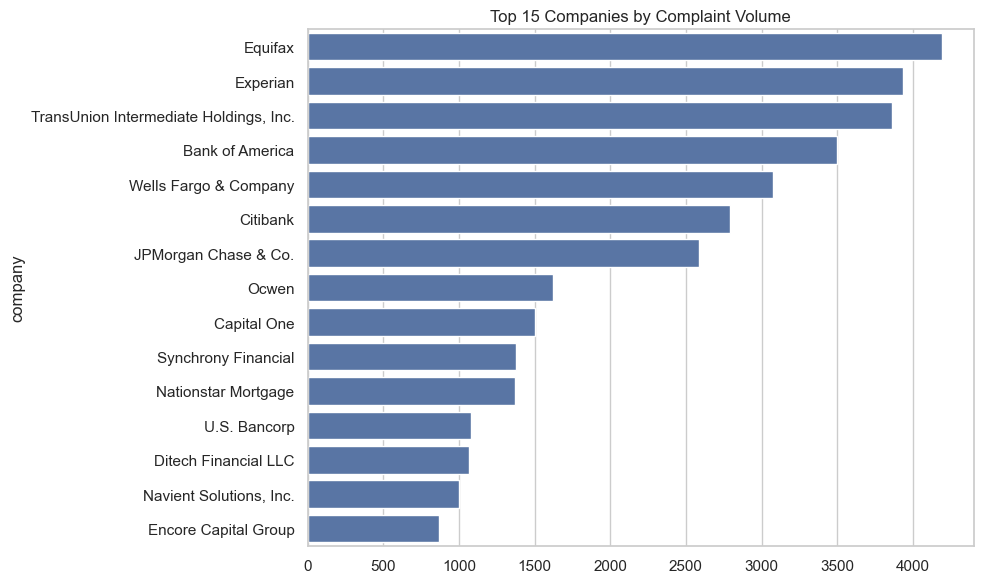

In [13]:
# Top companines by volume
top_comp = df['company'].value_counts().head(15)
top_comp
plt.figure(figsize=(10,6))
sns.barplot(x=top_comp.values, y=top_comp.index)
plt.title("Top 15 Companies by Complaint Volume")
plt.tight_layout()
plt.show()

### Insights
* Equifax, Experian, Transunion Lead complaint counts.
* Other banks and services follow.
### Strategy
* Encode top 15 companies; group the rest as 'Other_Company'.
* Use company as categorical feature and for further analysis of response patterns.


# Feature engineering and Dataset Enhancement

In [14]:
#Impute missing sub_product
df['sub_product'] = df['sub_product'].fillna('Unknown')
df['sub_product']

0        Other (i.e. phone, health club, etc.)
1                                 Vehicle loan
2                  Conventional fixed mortgage
3                  Conventional fixed mortgage
4                  Conventional fixed mortgage
                         ...                  
66801                                  Unknown
66802                                  Unknown
66803                              Payday loan
66804              Conventional fixed mortgage
66805              Conventional fixed mortgage
Name: sub_product, Length: 66806, dtype: object

In [15]:
#Encode products and companies
top_products = df['product'].value_counts().nlargest(5).index
df['product_enc'] = df['product'].apply(lambda x:x if x in top_products else 'Other_Product')
df['product_enc']
df.drop('product', axis=1)

,sub_product,issue,company,state,timely_response,text_cleaned,consumer_disputed_binary,timely_response_binary,company_response_encoded,text_length,product_enc
0,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,"Diversified Consultants, Inc.",NY,Yes,xxxx has claimed i owe them for xxxx years des...,0,1,1,52,Debt collection
1,Vehicle loan,Managing the loan or lease,M&T Bank Corporation,VA,Yes,due to inconsistencies in the amount owed that...,0,1,1,238,Other_Product
2,Conventional fixed mortgage,"Loan modification,collection,foreclosure",Wells Fargo & Company,CA,Yes,in xxxxxxxx my wages that i earned at my job d...,1,1,1,655,Mortgage
3,Conventional fixed mortgage,"Loan servicing, payments, escrow account",JPMorgan Chase & Co.,CA,Yes,i have an open and current mortgage with chase...,1,1,1,74,Mortgage
4,Conventional fixed mortgage,Credit decision / Underwriting,Rushmore Loan Management Services LLC,CA,Yes,xxxx was submitted xxxxxxxx at the time i subm...,1,1,1,259,Mortgage
...,...,...,...,...,...,...,...,...,...,...,...
66801,Unknown,Incorrect information on credit report,"TransUnion Intermediate Holdings, Inc.",WA,Yes,xxxx xxxx is reporting incorrectly payments ha...,0,1,1,20,Credit reporting
66802,Unknown,Incorrect information on credit report,"TransUnion Intermediate Holdings, Inc.",WA,Yes,reflecting incorrect payment status have been ...,0,1,1,8,Credit reporting
66803,Payday loan,Charged fees or interest I didn't expect,Zarvad III S.A.,NV,Yes,i have been paying a month through direct debi...,0,1,1,116,Other_Product
66804,Conventional fixed mortgage,"Application, originator, mortgage broker",Amerisave,AZ,Yes,i recently became aware that amerisave mortgag...,1,1,1,224,Mortgage


In [16]:
top_companies = df['company'].value_counts().nlargest(15).index
df['company_enc'] = df['company'].apply(lambda x: x if x in top_companies else 'Other_Company')
df['company_enc']
df.drop('company', axis = 1)

,product,sub_product,issue,state,timely_response,text_cleaned,consumer_disputed_binary,timely_response_binary,company_response_encoded,text_length,product_enc,company_enc
0,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,NY,Yes,xxxx has claimed i owe them for xxxx years des...,0,1,1,52,Debt collection,Other_Company
1,Consumer Loan,Vehicle loan,Managing the loan or lease,VA,Yes,due to inconsistencies in the amount owed that...,0,1,1,238,Other_Product,Other_Company
2,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",CA,Yes,in xxxxxxxx my wages that i earned at my job d...,1,1,1,655,Mortgage,Wells Fargo & Company
3,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",CA,Yes,i have an open and current mortgage with chase...,1,1,1,74,Mortgage,JPMorgan Chase & Co.
4,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,CA,Yes,xxxx was submitted xxxxxxxx at the time i subm...,1,1,1,259,Mortgage,Other_Company
...,...,...,...,...,...,...,...,...,...,...,...,...
66801,Credit reporting,Unknown,Incorrect information on credit report,WA,Yes,xxxx xxxx is reporting incorrectly payments ha...,0,1,1,20,Credit reporting,"TransUnion Intermediate Holdings, Inc."
66802,Credit reporting,Unknown,Incorrect information on credit report,WA,Yes,reflecting incorrect payment status have been ...,0,1,1,8,Credit reporting,"TransUnion Intermediate Holdings, Inc."
66803,Payday loan,Payday loan,Charged fees or interest I didn't expect,NV,Yes,i have been paying a month through direct debi...,0,1,1,116,Other_Product,Other_Company
66804,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",AZ,Yes,i recently became aware that amerisave mortgag...,1,1,1,224,Mortgage,Other_Company


In [17]:
# Create dispute rate feature
prod_rate = df.groupby('product')['consumer_disputed_binary'].mean() 
prod_rate
df['product_dispute_rate'] = df['product'].map(prod_rate)
df['product_dispute_rate']

0        0.222881
1        0.247961
2        0.267176
3        0.267176
4        0.267176
           ...   
66801    0.214354
66802    0.214354
66803    0.166667
66804    0.267176
66805    0.267176
Name: product_dispute_rate, Length: 66806, dtype: float64

In [18]:
# Normalize text length
df['text_length_norm'] = (df['text_length']-df['text_length'].mean())/df['text_length'].std()
df['text_length_norm']

0       -0.824728
1        0.328141
2        2.912801
3       -0.688367
4        0.458304
           ...   
66801   -1.023071
66802   -1.097450
66803   -0.428042
66804    0.241366
66805    2.720656
Name: text_length_norm, Length: 66806, dtype: float64

In [19]:
# Final dataset columns
enhanced = df[['product_enc','sub_product','issue','company_enc',
               'state','timely_response_binary','text_cleaned',
               'text_length_norm','product_dispute_rate','consumer_disputed_binary']]
enhanced.head()

,product_enc,sub_product,issue,company_enc,state,timely_response_binary,text_cleaned,text_length_norm,product_dispute_rate,consumer_disputed_binary
0,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Other_Company,NY,1,xxxx has claimed i owe them for xxxx years des...,-0.824728,0.222881,0
1,Other_Product,Vehicle loan,Managing the loan or lease,Other_Company,VA,1,due to inconsistencies in the amount owed that...,0.328141,0.247961,0
2,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",Wells Fargo & Company,CA,1,in xxxxxxxx my wages that i earned at my job d...,2.912801,0.267176,1
3,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",JPMorgan Chase & Co.,CA,1,i have an open and current mortgage with chase...,-0.688367,0.267176,1
4,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,Other_Company,CA,1,xxxx was submitted xxxxxxxx at the time i subm...,0.458304,0.267176,1


In [20]:
# Save enhanced data
enhanced.to_csv("../data/processed/enhanced_consumer_complaints.csv", index = False)

### Summary
* Missing sub_product handled.
* Categorical features reduced complexity.
* Numeric features normalized; new dispute rate included.
* Saved enhanced dataset to CSV

In [21]:
summary = """### Summary
* Missing sub_product handled.
* Categorical features reduced complexity.
* Numeric features normalized; new dispute rate included.
* Saved enhanced dataset to CSV
"""

with open('../outputs/profiling/enhanced_data_summary.md', 'w') as f:
    f.write(summary)

print("Summary saved to enhanced_data_summary.md")

Summary saved to enhanced_data_summary.md
